In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2022-12-06 03:30:15.855150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 03:30:15.978007: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-06 03:30:16.410200: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-06 03:30:16.410240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Num GPUs Available:  1


2022-12-06 03:30:16.923435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 03:30:16.948144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 03:30:16.948306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# LSTM with Dropout for sequence classification in the IMDB dataset
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

In [4]:
tf.__version__

'2.11.0'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
np.__version__

'1.23.4'

In [7]:
data = pd.read_csv("OPV_data_SMILES.csv")
data = data[["PCE", "SMILES-D"]]
data.head(5)

,PCE,SMILES-D
0,1.36,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...
1,1.24,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...
2,3.16,CCCCCCc1c(/C=C/c2sc(c(c2CCCCCC)CCCCCC)C=C(C#N)...
3,2.10,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...
4,2.70,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...


## EDA

In [8]:
data_LSTM = data[['SMILES-D', 'PCE']]

In [9]:
maxPCE = data_LSTM['PCE'].max()
minPCE = data_LSTM['PCE'].min()
print(maxPCE, minPCE)

12.08 0.003


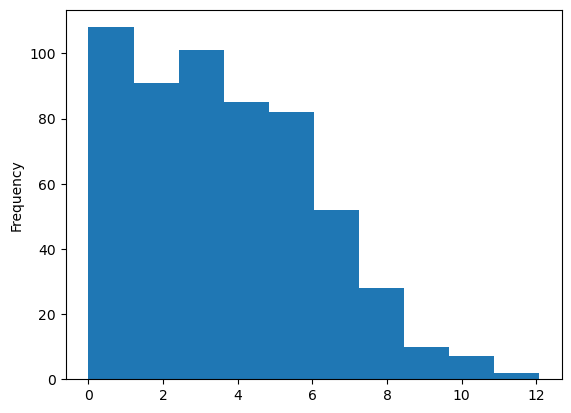

In [10]:
pce_val = data_LSTM['PCE']
pce_val.plot(kind='hist')
plt.show()

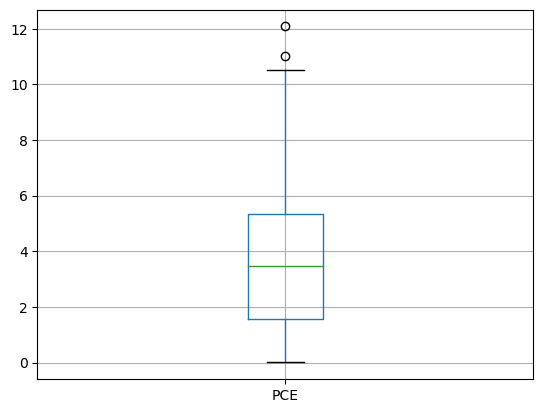

In [11]:
pce_val_bxplt = data_LSTM.boxplot(column = 'PCE')
pce_val_bxplt.plot()
plt.show()

## Create labels

In [12]:
def categorise(row):
    if row['PCE'] > 3.15:
        return 1
    elif row['PCE'] <= 3.15:
        return 0

In [13]:
data_LSTM['LABEL'] = data_LSTM.apply(lambda row: categorise(row), axis=1)
data_LSTM.head(5)

/tmp/ipykernel_278677/1828102457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_LSTM['LABEL'] = data_LSTM.apply(lambda row: categorise(row), axis=1)


,SMILES-D,PCE,LABEL
0,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...,1.36,0
1,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...,1.24,0
2,CCCCCCc1c(/C=C/c2sc(c(c2CCCCCC)CCCCCC)C=C(C#N)...,3.16,1
3,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...,2.10,0
4,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...,2.70,0


In [14]:
data_LSTM.rename(columns = {'SMILES-D':'SMILES_D'}, inplace=True)

/tmp/ipykernel_278677/4024915585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_LSTM.rename(columns = {'SMILES-D':'SMILES_D'}, inplace=True)


In [15]:
data_LSTM

,SMILES_D,PCE,LABEL
0,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...,1.36,0
1,CCCCCCc1c(C#CC2=C3CCC4N3[Zn@@]35n6c2ccc6C(=C2N...,1.24,0
2,CCCCCCc1c(/C=C/c2sc(c(c2CCCCCC)CCCCCC)C=C(C#N)...,3.16,1
3,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...,2.10,0
4,CCCC[C@H](Cn1c2cc(ccc2c2c1c1c(c3c2n(C[C@H](CCC...,2.70,0
...,...,...,...
561,CCCC[C@H](CSc1ccc(s1)c1c2cc(sc2c(c2c1sc(c2)c1s...,4.50,1
562,CCCC[C@H](CSc1ccc(s1)c1c2cc(sc2c(c2c1sc(c2)c1s...,4.30,1
563,CCCC[C@H](Cc1ccc(s1)c1c2cc(sc2c(c2c1sc(c2)c1cc...,1.70,0
564,CCCC[C@H](Cc1ccc(s1)c1c2sc(cc2c(c2c1cc(s2)C1=[...,10.52,1


In [76]:
X_LSTM = data_LSTM['SMILES_D']
Y_LSTM = data_LSTM['PCE']

In [103]:
vocab_size = 500#1000
tokenizer = tf.keras.preprocessing.text.Tokenizer(vocab_size, filters="", char_level=True)
tokenizer.fit_on_texts(X_LSTM)

In [104]:
# sequence padding
seqs = tokenizer.texts_to_sequences(X_LSTM)
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post')

In [105]:
x_train, x_test, y_train, y_test = (train_test_split(padded_seqs, Y_LSTM, test_size = 0.20))

In [106]:
x_train.shape

(452, 1373)

In [107]:
x_train[0].shape

(1373,)

In [108]:
y_train.shape

(452,)

In [115]:
model = Sequential()
model.add(Embedding(input_dim=50, output_dim=32, mask_zero=True))

model.add(Bidirectional(LSTM(256, return_sequences=True)))#, input_shape=(50, 500)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1, activation="relu"))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 32)          1600      
                                                                 
 bidirectional_28 (Bidirecti  (None, None, 512)        591872    
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, None, 512)         0         
                                                                 
 bidirectional_29 (Bidirecti  (None, 128)              295424    
 onal)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 1)               

In [116]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse', 'mae'])

In [117]:
result = model.fit(x_train, y_train, validation_split =0.15,batch_size=60, epochs=450, verbose=1)
#scores = model.evaluate(x_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/450
7/7 [==============================] - 11s 525ms/step - loss: 13.7762 - mse: 13.7762 - mae: 2.9557 - val_loss: 11.6035 - val_mse: 11.6035 - val_mae: 2.9169
Epoch 2/450
7/7 [==============================] - 1s 138ms/step - loss: 7.3746 - mse: 7.3746 - mae: 2.2209 - val_loss: 5.9051 - val_mse: 5.9051 - val_mae: 2.0195
Epoch 3/450
7/7 [==============================] - 1s 109ms/step - loss: 6.0078 - mse: 6.0078 - mae: 1.9827 - val_loss: 5.7082 - val_mse: 5.7082 - val_mae: 2.0875
Epoch 4/450
7/7 [==============================] - 1s 118ms/step - loss: 5.8858 - mse: 5.8858 - mae: 2.0051 - val_loss: 5.8023 - val_mse: 5.8023 - val_mae: 2.1097
Epoch 5/450
7/7 [==============================] - 1s 112ms/step - loss: 5.8600 - mse: 5.8600 - mae: 1.9960 - val_loss: 5.6361 - val_mse: 5.6361 - val_mae: 2.0640
Epoch 6/450
7/7 [==============================] - 1s 98ms/step - loss: 5.8620 - mse: 5.8620 - mae: 1.9769 - val_loss: 5.6065 - val_mse: 5.6065 - val_mae: 2.0501
Epoch 7/450
7/7 [=

7/7 [==============================] - 1s 104ms/step - loss: 5.4368 - mse: 5.4368 - mae: 1.9053 - val_loss: 5.3083 - val_mse: 5.3083 - val_mae: 2.0355
Epoch 52/450
7/7 [==============================] - 1s 104ms/step - loss: 5.4274 - mse: 5.4274 - mae: 1.9030 - val_loss: 5.3429 - val_mse: 5.3429 - val_mae: 2.0439
Epoch 53/450
7/7 [==============================] - 1s 109ms/step - loss: 5.4116 - mse: 5.4116 - mae: 1.8889 - val_loss: 5.3121 - val_mse: 5.3121 - val_mae: 2.0360
Epoch 54/450
7/7 [==============================] - 1s 105ms/step - loss: 5.4225 - mse: 5.4225 - mae: 1.9079 - val_loss: 5.3599 - val_mse: 5.3599 - val_mae: 2.0453
Epoch 55/450
7/7 [==============================] - 1s 105ms/step - loss: 5.3894 - mse: 5.3894 - mae: 1.8735 - val_loss: 5.2862 - val_mse: 5.2862 - val_mae: 2.0194
Epoch 56/450
7/7 [==============================] - 1s 97ms/step - loss: 5.4267 - mse: 5.4267 - mae: 1.9075 - val_loss: 5.3500 - val_mse: 5.3500 - val_mae: 2.0393
Epoch 57/450
7/7 [============

Epoch 151/450
7/7 [==============================] - 1s 108ms/step - loss: 5.2492 - mse: 5.2492 - mae: 1.8433 - val_loss: 5.2002 - val_mse: 5.2002 - val_mae: 1.9709
Epoch 152/450
7/7 [==============================] - 1s 97ms/step - loss: 5.1593 - mse: 5.1593 - mae: 1.8270 - val_loss: 5.1952 - val_mse: 5.1952 - val_mae: 1.9690
Epoch 153/450
7/7 [==============================] - 1s 103ms/step - loss: 5.2068 - mse: 5.2068 - mae: 1.8412 - val_loss: 5.1854 - val_mse: 5.1854 - val_mae: 1.9673
Epoch 154/450
7/7 [==============================] - 1s 108ms/step - loss: 5.2701 - mse: 5.2701 - mae: 1.8730 - val_loss: 5.2003 - val_mse: 5.2003 - val_mae: 1.9737
Epoch 155/450
7/7 [==============================] - 1s 106ms/step - loss: 5.2654 - mse: 5.2654 - mae: 1.8536 - val_loss: 5.2086 - val_mse: 5.2086 - val_mae: 1.9718
Epoch 156/450
7/7 [==============================] - 1s 99ms/step - loss: 5.1541 - mse: 5.1541 - mae: 1.8526 - val_loss: 5.2130 - val_mse: 5.2130 - val_mae: 1.9740
Epoch 157/45

Epoch 201/450
7/7 [==============================] - 1s 99ms/step - loss: 5.1338 - mse: 5.1338 - mae: 1.8267 - val_loss: 5.1263 - val_mse: 5.1263 - val_mae: 1.9444
Epoch 202/450
7/7 [==============================] - 1s 98ms/step - loss: 5.2465 - mse: 5.2465 - mae: 1.8296 - val_loss: 5.2186 - val_mse: 5.2186 - val_mae: 1.9647
Epoch 203/450
7/7 [==============================] - 1s 106ms/step - loss: 5.1163 - mse: 5.1163 - mae: 1.8026 - val_loss: 5.1610 - val_mse: 5.1610 - val_mae: 1.9489
Epoch 204/450
7/7 [==============================] - 1s 107ms/step - loss: 5.0979 - mse: 5.0979 - mae: 1.8180 - val_loss: 5.1646 - val_mse: 5.1646 - val_mae: 1.9455
Epoch 205/450
7/7 [==============================] - 1s 101ms/step - loss: 5.2754 - mse: 5.2754 - mae: 1.8432 - val_loss: 5.1652 - val_mse: 5.1652 - val_mae: 1.9568
Epoch 206/450
7/7 [==============================] - 1s 99ms/step - loss: 5.1115 - mse: 5.1115 - mae: 1.8234 - val_loss: 5.1620 - val_mse: 5.1620 - val_mae: 1.9514
Epoch 207/450

Epoch 251/450
7/7 [==============================] - 1s 103ms/step - loss: 5.1620 - mse: 5.1620 - mae: 1.8206 - val_loss: 5.2579 - val_mse: 5.2579 - val_mae: 1.9730
Epoch 252/450
7/7 [==============================] - 1s 100ms/step - loss: 5.1553 - mse: 5.1553 - mae: 1.8179 - val_loss: 5.2621 - val_mse: 5.2621 - val_mae: 1.9765
Epoch 253/450
7/7 [==============================] - 1s 107ms/step - loss: 5.1008 - mse: 5.1008 - mae: 1.8179 - val_loss: 5.2262 - val_mse: 5.2262 - val_mae: 1.9699
Epoch 254/450
7/7 [==============================] - 1s 106ms/step - loss: 5.0923 - mse: 5.0923 - mae: 1.8192 - val_loss: 5.1834 - val_mse: 5.1834 - val_mae: 1.9599
Epoch 255/450
7/7 [==============================] - 1s 97ms/step - loss: 5.1421 - mse: 5.1421 - mae: 1.8086 - val_loss: 5.2888 - val_mse: 5.2888 - val_mae: 1.9417
Epoch 256/450
7/7 [==============================] - 1s 109ms/step - loss: 5.1261 - mse: 5.1261 - mae: 1.7998 - val_loss: 5.2269 - val_mse: 5.2269 - val_mae: 1.9428
Epoch 257/4

Epoch 301/450
7/7 [==============================] - 1s 99ms/step - loss: 5.0108 - mse: 5.0108 - mae: 1.8029 - val_loss: 5.0489 - val_mse: 5.0489 - val_mae: 1.9668
Epoch 302/450
7/7 [==============================] - 1s 102ms/step - loss: 4.9471 - mse: 4.9471 - mae: 1.7931 - val_loss: 4.9962 - val_mse: 4.9962 - val_mae: 1.9344
Epoch 303/450
7/7 [==============================] - 1s 101ms/step - loss: 4.8465 - mse: 4.8465 - mae: 1.7705 - val_loss: 5.0315 - val_mse: 5.0315 - val_mae: 1.9430
Epoch 304/450
7/7 [==============================] - 1s 94ms/step - loss: 4.8257 - mse: 4.8257 - mae: 1.7593 - val_loss: 5.0137 - val_mse: 5.0137 - val_mae: 1.9253
Epoch 305/450
7/7 [==============================] - 1s 104ms/step - loss: 4.7842 - mse: 4.7842 - mae: 1.7606 - val_loss: 4.9749 - val_mse: 4.9749 - val_mae: 1.9210
Epoch 306/450
7/7 [==============================] - 1s 100ms/step - loss: 4.8214 - mse: 4.8214 - mae: 1.7660 - val_loss: 4.8834 - val_mse: 4.8834 - val_mae: 1.9045
Epoch 307/45

Epoch 351/450
7/7 [==============================] - 1s 101ms/step - loss: 3.9873 - mse: 3.9873 - mae: 1.5713 - val_loss: 5.0894 - val_mse: 5.0894 - val_mae: 1.9998
Epoch 352/450
7/7 [==============================] - 1s 101ms/step - loss: 3.9265 - mse: 3.9265 - mae: 1.5706 - val_loss: 5.4902 - val_mse: 5.4902 - val_mae: 2.0318
Epoch 353/450
7/7 [==============================] - 1s 98ms/step - loss: 3.9114 - mse: 3.9114 - mae: 1.5633 - val_loss: 5.6803 - val_mse: 5.6803 - val_mae: 2.0901
Epoch 354/450
7/7 [==============================] - 1s 100ms/step - loss: 4.1220 - mse: 4.1220 - mae: 1.6077 - val_loss: 5.5063 - val_mse: 5.5063 - val_mae: 1.9978
Epoch 355/450
7/7 [==============================] - 1s 109ms/step - loss: 4.3863 - mse: 4.3863 - mae: 1.6839 - val_loss: 5.1987 - val_mse: 5.1987 - val_mae: 1.9552
Epoch 356/450
7/7 [==============================] - 1s 108ms/step - loss: 4.2194 - mse: 4.2194 - mae: 1.6231 - val_loss: 5.1099 - val_mse: 5.1099 - val_mae: 1.9738
Epoch 357/4

Epoch 401/450
7/7 [==============================] - 1s 104ms/step - loss: 4.2140 - mse: 4.2140 - mae: 1.6324 - val_loss: 4.8943 - val_mse: 4.8943 - val_mae: 1.8949
Epoch 402/450
7/7 [==============================] - 1s 105ms/step - loss: 4.1485 - mse: 4.1485 - mae: 1.6028 - val_loss: 5.2174 - val_mse: 5.2174 - val_mae: 1.9581
Epoch 403/450
7/7 [==============================] - 1s 102ms/step - loss: 3.8016 - mse: 3.8016 - mae: 1.5373 - val_loss: 4.8964 - val_mse: 4.8964 - val_mae: 1.8804
Epoch 404/450
7/7 [==============================] - 1s 92ms/step - loss: 4.1748 - mse: 4.1748 - mae: 1.6195 - val_loss: 5.5118 - val_mse: 5.5118 - val_mae: 1.9425
Epoch 405/450
7/7 [==============================] - 1s 98ms/step - loss: 4.4846 - mse: 4.4846 - mae: 1.6958 - val_loss: 5.5132 - val_mse: 5.5132 - val_mae: 1.9585
Epoch 406/450
7/7 [==============================] - 1s 109ms/step - loss: 4.3624 - mse: 4.3624 - mae: 1.6458 - val_loss: 4.9640 - val_mse: 4.9640 - val_mae: 1.8972
Epoch 407/45

In [118]:
result.history

{'loss': [13.776222229003906,
  7.374555587768555,
  6.0078125,
  5.885753154754639,
  5.860010147094727,
  5.86195707321167,
  5.88887357711792,
  5.9720940589904785,
  5.859355449676514,
  5.953877925872803,
  5.92133092880249,
  5.941762924194336,
  5.9027886390686035,
  5.880802154541016,
  6.104635715484619,
  6.087967395782471,
  5.913816452026367,
  5.889289855957031,
  5.803229808807373,
  5.841529846191406,
  5.845975399017334,
  5.9106879234313965,
  5.793639659881592,
  5.7123122215271,
  5.578929424285889,
  7.530772686004639,
  5.6523356437683105,
  5.761516571044922,
  5.640720367431641,
  5.711270809173584,
  5.708210468292236,
  5.658010005950928,
  5.69297981262207,
  5.6613006591796875,
  5.517384052276611,
  5.680064678192139,
  5.54527473449707,
  5.542327880859375,
  5.535895824432373,
  5.612301349639893,
  5.492279052734375,
  5.595649719238281,
  5.542924880981445,
  5.542215824127197,
  5.638507843017578,
  5.457977771759033,
  5.435853958129883,
  5.4577922821

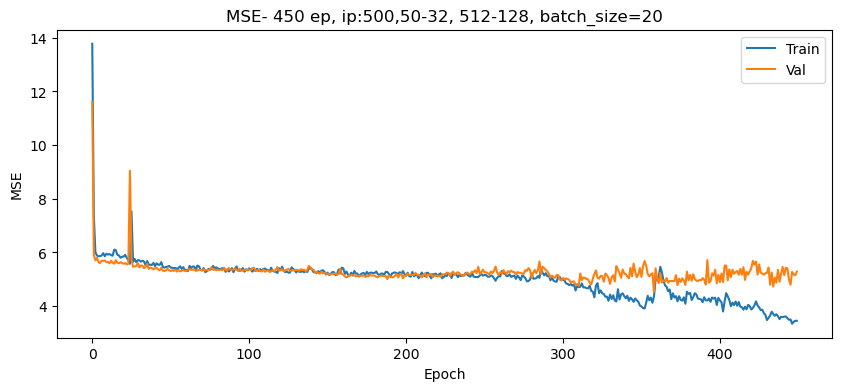

In [119]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(4)
plt.plot(result.history["mse"], label = "train")
plt.plot(result.history["val_mse"], label = "val")
plt.title("MSE- 450 ep, ip:500,50-32, 512-128, batch_size=20")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend(['Train', 'Val'])
#plt.show()

In [69]:
scores = model.evaluate(x_test, y_test, verbose = 0)
print("Mean Squared Error = ", scores[1])
print("Mean Absolute Error = ", scores[2])

Mean Squared Error =  5.802175998687744
Mean Absolute Error =  1.9609615802764893


In [70]:
y_pred = model.predict(x_test)

4/4 [==============================] - 3s 23ms/step


[]

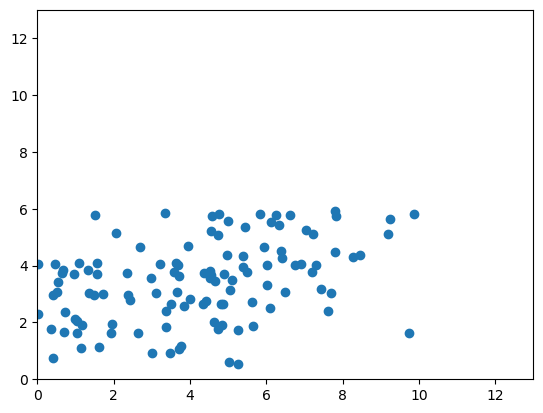

In [71]:
plt.scatter(y_test, y_pred)
plt.xlim([0,13])
plt.ylim([0,13])
plt.plot()

In [72]:
from sklearn.metrics import r2_score
print("R2: score", r2_score(y_test, y_pred))

R2: score 0.020189396218328937


In [2]:
'''
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(4)
plt.plot(result.history["accuracy"], label = "train")
plt.plot(result.history["val_accuracy"], label = "val")
plt.title("Accuracy- 250 ep, ip:300-128, 128-48, batch_size= 30")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Val'])
'''

'\nf = plt.figure()\nf.set_figwidth(10)\nf.set_figheight(4)\nplt.plot(result.history["accuracy"], label = "train")\nplt.plot(result.history["val_accuracy"], label = "val")\nplt.title("Accuracy- 250 ep, ip:300-128, 128-48, batch_size= 30")\nplt.xlabel("Epoch")\nplt.ylabel("Accuracy")\nplt.legend([\'Train\', \'Val\'])\n'

In [4]:
'''
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(4)
plt.plot(result.history["accuracy"], label = "train")
plt.plot(result.history["val_accuracy"], label = "val")
plt.title("Accuracy- 100 ep, ip:500-150, 150-55, batch_size= 10")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Val'])
'''

'\nf = plt.figure()\nf.set_figwidth(10)\nf.set_figheight(4)\nplt.plot(result.history["accuracy"], label = "train")\nplt.plot(result.history["val_accuracy"], label = "val")\nplt.title("Accuracy- 100 ep, ip:500-150, 150-55, batch_size= 10")\nplt.xlabel("Epoch")\nplt.ylabel("Accuracy")\nplt.legend([\'Train\', \'Val\'])\n'

In [5]:
#scores = model.evaluate(x_test, y_test)